# FBI Crime Data Analysis

### Yu-Heng Lei (yuhengl1), Bo-Cheng Lin (bochengl), Xiaoyu Qiu (xiaoyuq)

## Motivation
Emerging crime incidents have raised awareness of personnel security. Therefore, it is becoming more important to understand crime data to identify key factors and their relationship with incidents behind the scene. Security agencies may leverage such analysis to gain insights and even influence their decision making.

## Libraries Used

For manipulating CSV files, we will use packages like `pandas` and `NumPy` to preprocess and reorganize them into DataFrames.

For data visualization, we will use `seaborn`, `Matplotlib`, `GeoPandas`, and `Shapely` for exploratory analysis to find interesting insight hidden in the data.

In [1]:
# Pre-processing
import collections
import numpy as np
import pandas as pd
import math

# General visualization 
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Geospatial visualization
import geopandas as gpd
import shapely
from shapely.geometry import Point
from geopy.geocoders import GoogleV3
from scipy import ndimage

# data processing for modeling
from sklearn.utils import shuffle
import datetime
from pandas.tseries.holiday import USFederalHolidayCalendar

# modeling
from sklearn.multioutput import MultiOutputClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingRegressor

# data evaluation
from sklearn.metrics import confusion_matrix

In [2]:
# Display otpions
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)
pd.set_option('max_colwidth', 100)
np.set_printoptions(linewidth=100)

## Project Outline

**TODO: Update with the correct sections and internal links**

This project will cover the following major sections:
- [Data Pre-processing](#Data-Pre-processing)
- [Exploratory Data Analysis](#Exploratory-Data-Analysis)
  - [Overall Statistics](#Overall-Statistics)
  - [Geospatial Distribution](#Geospatial-Distribution)
  - [Location Types with Different Offense Types](#Location-Types-with-Different-Offense-Types)
  - [Monthly Offense Distributions with Different Offense Types](#Monthly-Offense-Distributions-with-Different-Offense-Types)
  - [Offender-victim Relationship with Different Offense Types](#Offender-victim-Relationship-with-Different-Offense-Types)
  - [Offender-victim Age Comparison](#Offender-victim-Age-Comparison)
- [Offender Feature Prediction](#Offender-Feature-Prediction)
  - [Baseline Model](#Baseline-Model)
  - [Feature Engineering](#Feature-Engineering)
  - [Final Models](#Final-Models)
  - [Prediction Results](#Prediction-Results)
- [Summary](#Summary)

## Data Pre-processing

Our main dataset is the National Incident-Based Reporting System (NIBRS) dataset from FBI crime data explorer downloaded here:

- https://crime-data-explorer.fr.cloud.gov/downloads-and-docs

For a specific state-year combination, e.g., `PA-2016`, there are 43 CSV files that needs to be transformed into useful format. The `README` in the downloaded zip file provides explanation of some tables and variables.

According to the documentation, we need to establish the relationships between tables, such as mapping `offense_type_id` into the *human-readable* string `offense_name`.

First, define the 43 table names as lists or dictionaries. We will reuse them in *loops* later. The lookup tables are defined as a dictionary of `{tableName: (oldCol, newCol)}` format.

In [3]:
# 10 primary (more important) tables
primaryTables = [
    'nibrs_arrestee', 'nibrs_bias_motivation', 'nibrs_incident', 'nibrs_offender', 'nibrs_offense',
    'nibrs_property_desc', 'nibrs_property', 'nibrs_victim_injury', 'nibrs_victim_offender_rel', 'nibrs_victim'
]

# 24 lookup tables as a dictionary of {table_name: (oldCol, newCol)} format
lookupTables = {
    'nibrs_activity_type': ('activity_type_id', 'activity_type_name'),
    'nibrs_age': ('age_id', 'age_name'),
    'nibrs_arrest_type': ('arrest_type_id', 'arrest_type_name'), 
    'nibrs_assignment_type': ('assignment_type_id', 'assignment_type_name'),
    'nibrs_bias_list': ('bias_id', 'bias_name'),
    'nibrs_circumstances': ('circumstances_id', 'circumstances_name'),
    'nibrs_cleared_except': ('cleared_except_id', 'cleared_except_name'),
    'nibrs_criminal_act_type': ('criminal_act_id', 'criminal_act_name'),
    'nibrs_drug_measure_type': ('drug_measure_type_id', 'drug_measure_name'),
    'nibrs_ethnicity': ('ethnicity_id', 'ethnicity_name'),
    'nibrs_injury': ('injury_id', 'injury_name'),
    'nibrs_justifiable_force': ('justifiable_force_id', 'justifiable_force_name'),
    'nibrs_location_type': ('location_id', 'location_name'),
    'nibrs_month': ('nibrs_month_id', 'month_num'),
    'nibrs_offense_type' : ('offense_type_id', 'offense_name'),
    'nibrs_prop_desc_type': ('prop_desc_id', 'prop_desc_name'),
    'nibrs_prop_loss_type': ('prop_loss_id', 'prop_loss_name'),
    'nibrs_relationship': ('relationship_id', 'relationship_name'),
    'nibrs_suspected_drug_type': ('suspected_drug_type_id', 'suspected_drug_name'),
    'nibrs_using_list': ('suspect_using_id', 'suspect_using_name'),
    'nibrs_victim_type': ('victim_type_id', 'victim_type_name'),
    'nibrs_weapon_type': ('weapon_id', 'weapon_name'),
    'ref_race': ('race_id', 'race_desc'),
    'ref_state': ('state_id', 'state_name')
}

# 9 secondary (less important) tables
secondaryTables = [
    'agency_participation', 'cde_agencies', 'nibrs_arrestee_weapon', 'nibrs_criminal_act', 'nibrs_suspected_drug',
    'nibrs_suspect_using', 'nibrs_victim_circumstances', 'nibrs_victim_offense', 'nibrs_weapon'
]

The following function reads all 43 CSVs into a dictionary of DataFrames for a particular dataset. The dictionary keys are the NIBRS table names.

In this project, we mainly focus on the `PA-2016` dataset.


In [4]:
def readCSVs(dataset):
    """
    Read DataFrames into a dictionary with table names as keys
    Args:
        dataset (string): NIBRS dataset name, e.g., PA-2016
    Return:
        dic (dictionary): dictionary of DataFrames
    """
    print('Reading all CSVs for %s dataset...' % dataset)
    dic = {}
    for table in primaryTables + list(lookupTables.keys()) + secondaryTables:
        dic[table] = pd.read_csv("%s/%s.csv" % (dataset, table))
    print('Finished reading %d CSVs' % len(dic))
    return dic

PA2016 = readCSVs('PA-2016')

Reading all CSVs for PA-2016 dataset...
Finished reading 43 CSVs


Before further pre-processing, let's examine the data format in `nibrs_incident` and `nibrs_offense` DataFrames.

In [5]:
PA2016['nibrs_incident'].head(3)

,agency_id,incident_id,nibrs_month_id,incident_number,cargo_theft_flag,submission_date,incident_date,report_date_flag,incident_hour,cleared_except_id,cleared_except_date,incident_status,data_home,ddocname,orig_format,ff_line_number,did
0,16599,83457465,7292072,I00000431989,NaN,2017-11-06 00:00:00,2016-01-25 00:00:00,NaN,16,4,2016-01-26 00:00:00,0,C,2016_01_PA0363100_I00000431989_INC,F,NaN,2454966
1,16599,83457473,7292072,I00000432105,NaN,2017-11-06 00:00:00,2016-01-28 00:00:00,NaN,20,6,NaN,0,C,2016_01_PA0363100_I00000432105_INC,F,NaN,2454965
2,16599,83886692,7315872,I00000433344,NaN,2017-11-06 00:00:00,2016-02-27 00:00:00,NaN,16,6,NaN,0,C,2016_02_PA0363100_I00000433344_INC,F,NaN,3484972


In [6]:
PA2016['nibrs_offense'].head(3)

,offense_id,incident_id,offense_type_id,attempt_complete_flag,location_id,num_premises_entered,method_entry_code,ff_line_number
0,91124963,83457465,47,C,20,NaN,NaN,NaN
1,91124972,83457473,35,C,13,NaN,NaN,NaN
2,91618994,83886692,51,C,18,NaN,NaN,NaN


Clearly, some *IDs* used in the database need to be replaced by human-readable values, such as `nibrs_month_id`, `offense_type_id`, and `location_id`.

To do that, we will first create a nested dictionary of `{(oldCol, newCol): {oldValue: newValue}}` format from a lookup table. This nested dictionary can be reused by any dataset.

Following the style of the previous cell, we will write a for loop to create a nested dictionary.

In [7]:
def createMappings(dfs):
    """
    Create a nested dictionary of mappings 
    Args:
        dfs (dictionary): dictionary of DataFrames previously read
    Return:
        mappings (nested dictionary): {(oldCol, newCol): {oldValue: newValue}}
    """
    print('Creating lookup table mappings...')
    mappings = {}
    for table in lookupTables:
        # Only handle those with defined mapping
        if lookupTables[table] is not None:
            oldCol, newCol = lookupTables[table]
            mappings[(oldCol, newCol)] = dict(zip(dfs[table][oldCol], dfs[table][newCol]))
    print('Finished creating mappings from %d lookup tables' % len(mappings))
    return mappings

maps = createMappings(PA2016)

Creating lookup table mappings...
Finished creating mappings from 24 lookup tables


Finally, using the previously created nested dictionary, we will call [DataFrame.replace()](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.replace.html) with another nested dictionary argument of `{oldCol: {oldValue, newValue}}` format to perform the replacement in place. In the same function, we will also rename this `oldCol` as `newCol` for better readability.

In [8]:
def replaceAndRename(df, lookupTableNames):
    """
    Replace and rename DataFrame columns in place.
    Args:
        df (DataFrame): DataFrame to be replaced
        lookupTableNames (list): List of lookup table names for replacing and renaming
    """
    # Call df.replace() and df.rename() once for each changing column
    for lookupTableName in lookupTableNames:
        oldCol, newCol = lookupTables[lookupTableName]
        # dic: the nested dictionary required by df.replace()
        dic = {oldCol: maps[(oldCol, newCol)]}
        df.replace(dic, inplace=True)
        df.rename(columns={oldCol: newCol}, inplace=True)

print('Replacing and renaming columns...')
replaceAndRename(PA2016['nibrs_incident'], ['nibrs_month'])
replaceAndRename(PA2016['nibrs_offense'], ['nibrs_location_type', 'nibrs_offense_type'])
replaceAndRename(PA2016['nibrs_offender'], ['ref_race', 'nibrs_ethnicity'])
replaceAndRename(PA2016['nibrs_arrestee'], ['nibrs_offense_type', 'ref_race', 'nibrs_ethnicity'])
replaceAndRename(PA2016['nibrs_victim'], ['nibrs_victim_type', 'ref_race', 'nibrs_ethnicity'])
replaceAndRename(PA2016['nibrs_victim_offender_rel'], ['nibrs_relationship'])
replaceAndRename(PA2016['nibrs_property'], ['nibrs_prop_loss_type'])
replaceAndRename(PA2016['nibrs_property_desc'], ['nibrs_prop_desc_type'])
print('Done')

Replacing and renaming columns...
Done


### Merge Incident and Offense DFs

The schema in the incident and offense tables from NIBRS contain columns that would be useful when presenting in both, it is often more convenient to merge them as a single DataFrame called `incident_offense`.

Note that in NIBRS's documentation, an **incident** is defined as "one or more **offenses** committed by the same **offender**, or group of offenders acting in concert, at the same time and place". One incident can be associated with up to 10 offenses. 


In [9]:
PA2016['incident_offense'] = \
    PA2016['nibrs_incident'].merge(PA2016['nibrs_offense'], on='incident_id')
print('len(PA2016[\'incident_offense\']): %d' % len(PA2016['incident_offense']))

len(PA2016['incident_offense']): 6107


Indeed, all offenses map to exactly one incident as verified by the inner join. 

In [10]:
PA2016['incident_offense'].head()

,agency_id,incident_id,month_num,incident_number,cargo_theft_flag,submission_date,incident_date,report_date_flag,incident_hour,cleared_except_id,cleared_except_date,incident_status,data_home,ddocname,orig_format,ff_line_number_x,did,offense_id,offense_name,attempt_complete_flag,location_name,num_premises_entered,method_entry_code,ff_line_number_y
0,16599,83457465,1,I00000431989,NaN,2017-11-06 00:00:00,2016-01-25 00:00:00,NaN,16,4,2016-01-26 00:00:00,0,C,2016_01_PA0363100_I00000431989_INC,F,NaN,2454966,91124963,Theft From Building,C,Residence/Home,NaN,NaN,NaN
1,16599,83457473,1,I00000432105,NaN,2017-11-06 00:00:00,2016-01-28 00:00:00,NaN,20,6,NaN,0,C,2016_01_PA0363100_I00000432105_INC,F,NaN,2454965,91124972,Drug Equipment Violations,C,Highway/Road/Ally,NaN,NaN,NaN
2,16599,83886692,2,I00000433344,NaN,2017-11-06 00:00:00,2016-02-27 00:00:00,NaN,16,6,NaN,0,C,2016_02_PA0363100_I00000433344_INC,F,NaN,3484972,91618994,Simple Assault,C,Parking Lot/Garage,NaN,NaN,NaN
3,16599,84661377,4,I00000435734,NaN,2017-11-06 00:00:00,2016-04-24 00:00:00,NaN,13,6,NaN,0,C,2016_04_PA0363100_I00000435734_INC,F,NaN,5227634,92509421,Drug Equipment Violations,C,Residence/Home,NaN,NaN,NaN
4,16599,84661375,5,I00000437144,NaN,2017-11-06 00:00:00,2016-05-28 00:00:00,NaN,6,6,NaN,0,C,2016_05_PA0363100_I00000437144_INC,F,NaN,5227631,92508047,Simple Assault,C,Residence/Home,NaN,NaN,NaN


We can also observe from the merged DataFrame that `nibrs_month_id`, `offense_type_id`, and `location_id` are now replaced with the more meaningful `month_num`, `offense_name`, and `location_name`.

## Exploratory Data Analysis

### Helper Functions for Plotting

Since the NIBRS dataset contains mostly *categorical* variables, it's best to visualize them in count plots.

For code modularization, we will write a generic `countPlot()` function with several optional arguments to support different use cases.

In [11]:
def countPlot(df, col, hue=None, vertical=False, sort=True, topK=None, sortHues=True, topKHues=None, ret=False):
    """
    Helper function for calling sns.countplot()
    Args:
        df (DataFrame): DataFrame to be plotted
        col (string): Column (categorical variable) to be counted
        hue (string): Column (categorical variable) to be grouped by
        vertical (bool): Vertical bars
        sort (bool): Whether to sort bars by decreasing counts (True) or natural order (False)
        topK (int): Keep only top K bars. None: all bars
        sortHues (bool): Sort hues by decreasing counts (True) or natural order (False)
        topKHues (int): Group by only top K hues. None: all hues
        ret (bool): Whether to have a return value
    Return (optional):
        topValues (list): list of top K df[col] values
    """
    plt.figure(figsize=(8,6), dpi=100)
    if sort:
        topValues = df[col].value_counts().index[:topK]
    else:
        topValues = sorted(df[col].unique())[:topK]
        
    topHues = None
    if hue is not None:
        if sortHues:
            topHues = df[hue].value_counts().index[:topKHues]
        else:
            topHues = sorted(df[hue].unique())[:topKHues]
    
    if vertical:
        sns.countplot(data=df, x=col, order=topValues, hue=hue, hue_order=topHues)
    else:
        sns.countplot(data=df, y=col, order=topValues, hue=hue, hue_order=topHues)
    
    if ret:
        return list(topValues)


### Overall Statistics

First of all, let's count the major numbers in `PA-2016`, such as the number of incidents, offenses, offenders, and victims.

In [12]:
nIncidents = len(PA2016['nibrs_incident'])
nOffenses = len(PA2016['nibrs_offense'])
nOffenders = len(PA2016['nibrs_offender'])
nArrestees = len(PA2016['nibrs_arrestee'])
nVictims = len(PA2016['nibrs_victim'])
nIncidentsWithProp = len(PA2016['nibrs_property']['incident_id'].unique())
print('PA-2016 statistics:')
print('  %d incidents with %d offenses (%.2f per incident)'
      % (nIncidents, nOffenses, nOffenses / nIncidents))
print('  %d offenders (%.2f per incident), %d victims (%.2f per incident), %d (%.2f%%) arrestees'
      % (nOffenders, nOffenders / nIncidents, nVictims, nVictims / nIncidents,
         nArrestees, nArrestees / nOffenders * 100))
print('  %d (%.2f%%) incidents involve properties' %
      (nIncidentsWithProp, nIncidentsWithProp / nIncidents * 100))

PA-2016 statistics:
  5235 incidents with 6107 offenses (1.17 per incident)
  5928 offenders (1.13 per incident), 5930 victims (1.13 per incident), 2261 (38.14%) arrestees
  4292 (81.99%) incidents involve properties


### Geospatial Distribution

After playing with counting the data entries, we want to explore the geospatial data included in the dataset. Also, in order to present the geospatial data on a map to make it more informative to the audience, we also collect map data from the <a href="https://www.census.gov/geo/maps-data/data/cbf/cbf_blkgrp.html">United States Census Bereau</a>. Here we also leverage the `GeoPandas` and `Shapely` packages to help us visualize the data.

#### Join the agency_id tables
In order to plot the agencies on the map, we need to get latitude and longitude from the `cde_agencies` table first. By converting the latitude and longitude data into `geometry` column with `Shapely`'s `Point` data type, we could use GeoPandas to plot the geospatial map of each participating police department.

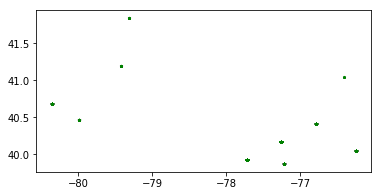

In [13]:
# PA2016["cde_agencies"].head()
# PA2016["nibrs_incident"].head()

tempDF = PA2016["cde_agencies"].merge(right=PA2016["nibrs_incident"], how="inner", on="agency_id")
agencyLatLonDF = tempDF[["incident_id", "icpsr_lat", "icpsr_lng"]]. \
    rename(columns={"icpsr_lat": "lat", "icpsr_lng": "lng"})
agencyLatLonDF['geometry'] = agencyLatLonDF.apply(lambda z: Point(z.lng, z.lat), axis=1)
agencyLatLonDF = gpd.GeoDataFrame(agencyLatLonDF)

agencyLatLonDF.crs = {'init' :'epsg:4326'}
agencyLatLonDF.plot(marker='*', color='green', markersize=5)

Next, we load the census data collected from the U.S. Census Bureau using GeoPandas and lay the dots we acquired in previous cell onto the map.

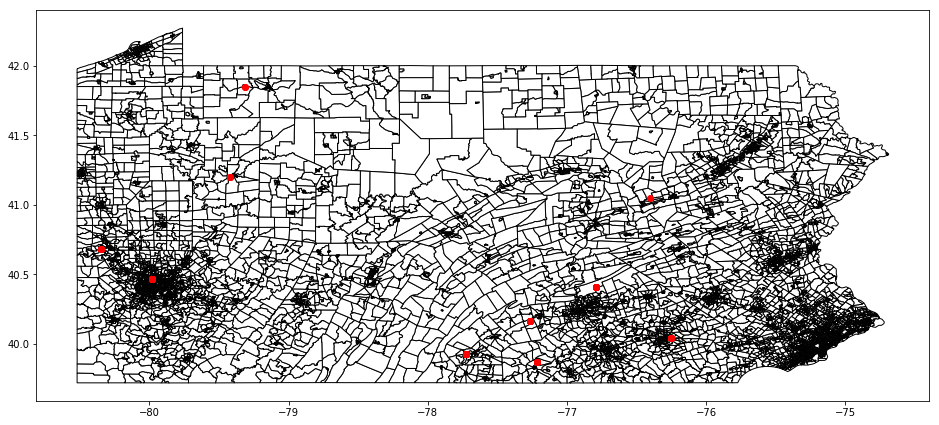

In [14]:
dfPA = gpd.read_file('PA-Geo/cb_2017_42_bg_500k.shp')
agencyLatLonDF = agencyLatLonDF.to_crs(dfPA.crs)
base = dfPA.plot(color='white', edgecolor='black', figsize=(16, 16))
agencyLatLonDF.plot(ax=base, marker='o', color='red', markersize=30, figsize=(16, 16))

Actually, there are only 28 unique coordinates in the `PA-2016` data with many overlapping points.

Finally, we tried presenting the dots and the frequencies of incidents associated with each dot using heatmap.

/Users/xiaoyuq/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in log
  del sys.path[0]


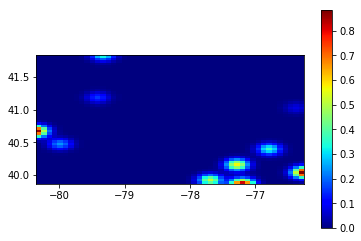

In [15]:
def heatmap(d, bins=(100,100), smoothing=1.3, cmap='jet'):
    def getx(pt):
        return pt.coords[0][0]

    def gety(pt):
        return pt.coords[0][1]

    x = list(d.geometry.apply(getx))
    y = list(d.geometry.apply(gety))
    heatmap, xedges, yedges = np.histogram2d(y, x, bins=bins)
    extent = [yedges[0], yedges[-1], xedges[-1], xedges[0]]

    logheatmap = np.log(heatmap)
    logheatmap[np.isneginf(logheatmap)] = 0
    logheatmap = ndimage.filters.gaussian_filter(logheatmap, smoothing, mode='nearest')
    
    plt.imshow(logheatmap, cmap=cmap, extent=extent)
    plt.colorbar()
    plt.gca().invert_yaxis()
    plt.show()
    
heatmap(agencyLatLonDF.dropna(axis = 0), bins=50, smoothing=1.5)

### Location Types with Different Offense Types

Before examining the relationship between variables, let's look at the top 10 most frequent offense types in `PA-2016` data.

/Users/xiaoyuq/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


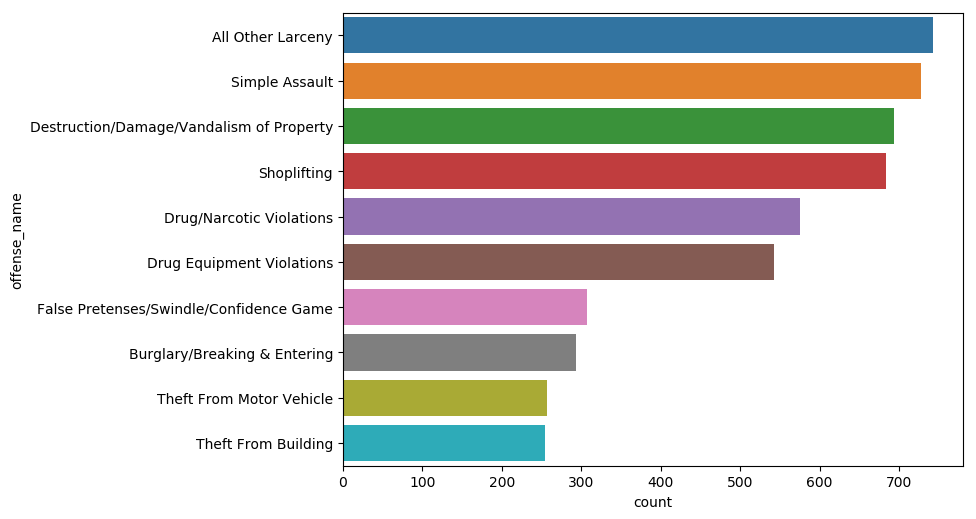

In [16]:
topCrimeTypes = countPlot(PA2016['nibrs_offense'], 'offense_name', topK=10, ret=True)

The most frequent offense types include, roughly speaking, larceny (theft such as shoplifting), simple assult, property damage, and drug violation.

Next, let's also look at the top 10 locations where these offenses occur.

/Users/xiaoyuq/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


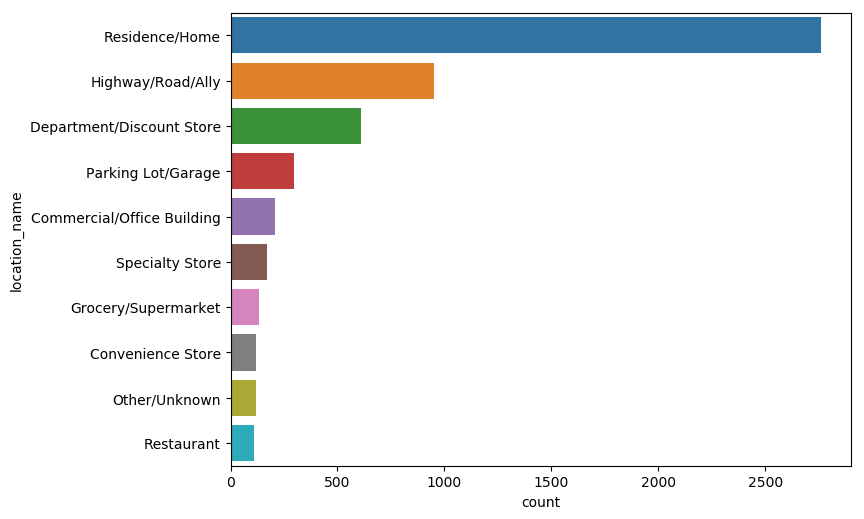

In [17]:
countPlot(PA2016['nibrs_offense'], 'location_name', topK=10)

Knowing the top offense types, it is not too surprising that the top locations are residence, road, and shops.

We can verify this relationship in another count plot conditioned on the top 5 location types. Then, compare the distributions of different colors (hues).

/Users/xiaoyuq/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:1508: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data[hue_mask])


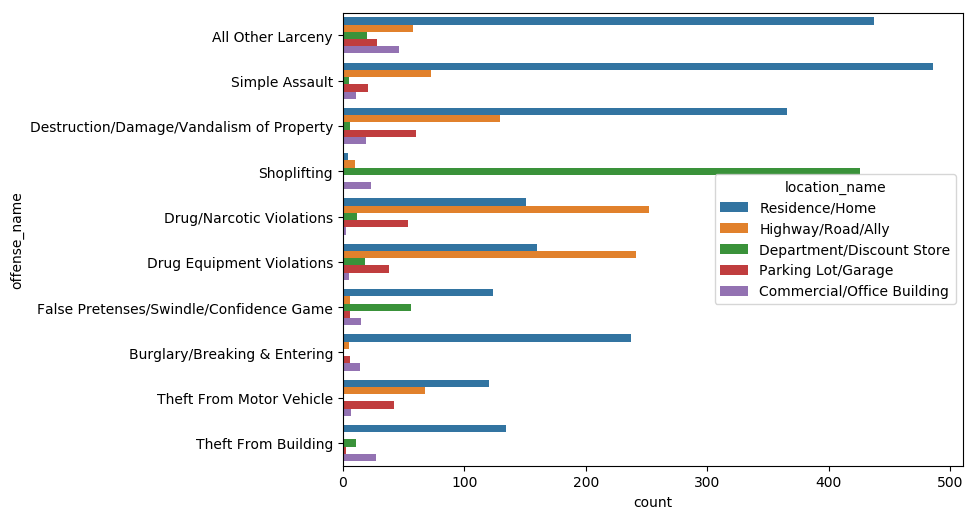

In [18]:
countPlot(PA2016['nibrs_offense'], 'offense_name', hue='location_name', topK=10, topKHues=5)

The most concentrated distribution is department/discount stores, where most offenses are shoplifting.

In addition, drug violations are of top frequency on the road and garage, but of moderate frequency at residence.

Instead, the most frequent offense types at residence locations are thefts, simple assault, and property damage.

### Monthly Offense Distributions with Different Offense Types

As another factor, let's examine how offenses are distributed over months by a count plot.

/Users/xiaoyuq/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


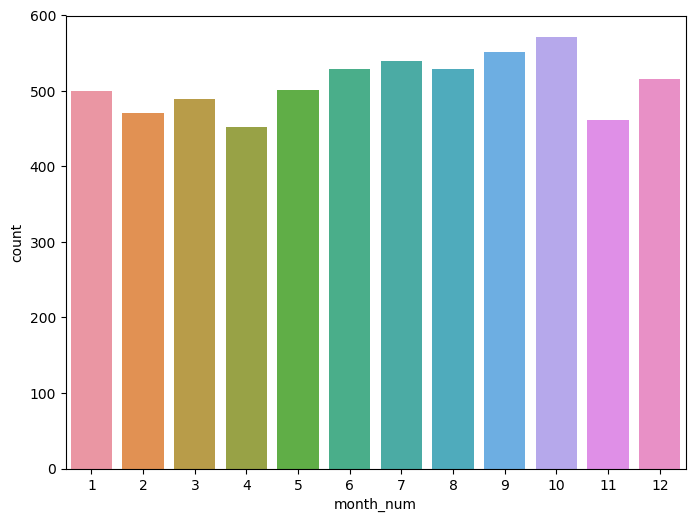

In [19]:
# Offense distribution by month
countPlot(PA2016['incident_offense'], 'month_num', vertical=True, sort=False)

The above distribution shows some small peaks in number of offenses in the summer and fall seasons (June through October).

We were wondering whether the monthly offense distributions agree when conditioned on each offense type, so we can make a similar count plot grouped by the top 5 offense types.

/Users/xiaoyuq/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:1508: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data[hue_mask])


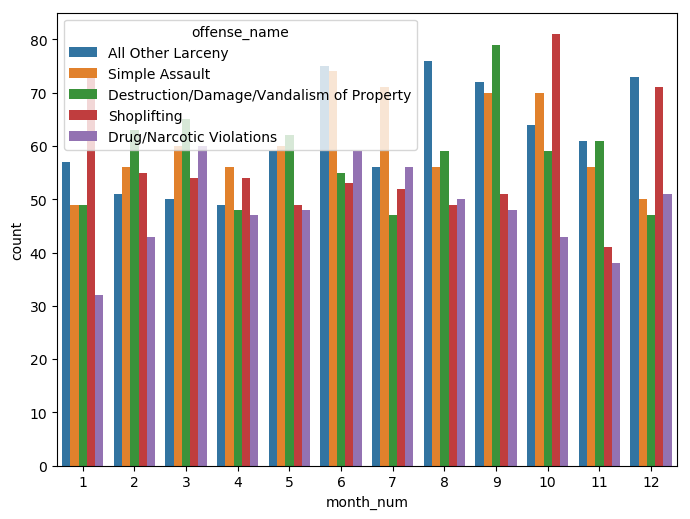

In [20]:
# Offense distribution by (offense type, month)
countPlot(PA2016['incident_offense'], 'month_num', hue='offense_name', \
          vertical=True, sort=False, sortHues=True, topKHues=5)

Interestingly, different offense types have quite different peak and off months. For example, Janurary is considered a off month for drug violation, but a peak month for shoplifting.

### Offender-victim Relationship with Different Offense Types

The `relationship` data in the NIBRS seems really interesting to us. Here we are particularly interested in the relationship between the victim/offender and how does it correlate with the crime type that had been committed on the victim.

#### Joining the tables

In order to analyze the relationship between the `relationship between victim/offender` and `offense type`, we first need to join three dataframes we need, which would be `nibrs_victim_offense`, `nibrs_offense`, and `nibrs_victim_offender_rel`. The NIBRS dataset includes non-human objects such as places or properties as victim. Since there's no relationship between a place or object and a human (or actually there is?), we should get a smaller joined dataframe after the joining process.

In [21]:
victim = PA2016["nibrs_victim_offense"]
print(len(victim))
print(len(victim["offense_id"].unique()))
victim.head()

6684
6107


,victim_id,offense_id
0,91038017,91124963
1,91038028,91124972
2,91526928,91618994
3,91526926,91618994
4,92412201,92509421


Here we plot the top 10 frequent offense type in our data set. Note that the frquency here might not be consistent with the joining results.

In [22]:
offense = PA2016["nibrs_offense"][["offense_id", "incident_id", "offense_name", "location_name"]]
print(len(offense))
offense.head()

6107


,offense_id,incident_id,offense_name,location_name
0,91124963,83457465,Theft From Building,Residence/Home
1,91124972,83457473,Drug Equipment Violations,Highway/Road/Ally
2,91618994,83886692,Simple Assault,Parking Lot/Garage
3,92509421,84661377,Drug Equipment Violations,Residence/Home
4,92508047,84661375,Simple Assault,Residence/Home


In [23]:
rel = PA2016["nibrs_victim_offender_rel"]
print(len(rel))
rel.head()

1277


,victim_id,offender_id,relationship_name,nibrs_victim_offender_id
0,91526928,94571285,Victim Was Acquaintance,27648864
1,91526928,94571283,Victim Was Acquaintance,27648863
2,91526926,94571285,Victim Was Acquaintance,27648862
3,91526926,94571283,Victim Was Acquaintance,27648076
4,92410630,95465950,Victim Was Boyfriend/Girlfriend,27913447


The joined dataframe has 1344 rows in it and not all top 10 offense types show up in it. This is because either the `nibrs_victim_offender_rel` table is not complete, or the victims of a particular offense type is not human (thus has no relationship between offender and victim based on the reasoning in the previous cell).

In [24]:
joinedVictimOffense = victim.merge(right = offense, on = "offense_id", how = "inner")\
                            .merge(right = rel, on = "victim_id", how = "inner")
print(len(joinedVictimOffense))
joinedVictimOffense.head()
# print(topCrimeTypes)
joinedVictimOffense = joinedVictimOffense[joinedVictimOffense["offense_name"].isin(topCrimeTypes)]
print(len(joinedVictimOffense))
print(joinedVictimOffense["offense_name"].unique())

1344
977
['Simple Assault' 'All Other Larceny' 'Burglary/Breaking & Entering'
 'Destruction/Damage/Vandalism of Property' 'Theft From Motor Vehicle' 'Theft From Building']


First thing we could do with our processed data is to do the counting plot of it. In our plot we found that there's a huge inbalance in our dataset that `Simple Assault` offenses are way more common than other offense type. To address this issue, we could normalize the data w.r.t the offense type itself.

/Users/xiaoyuq/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:1508: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data[hue_mask])


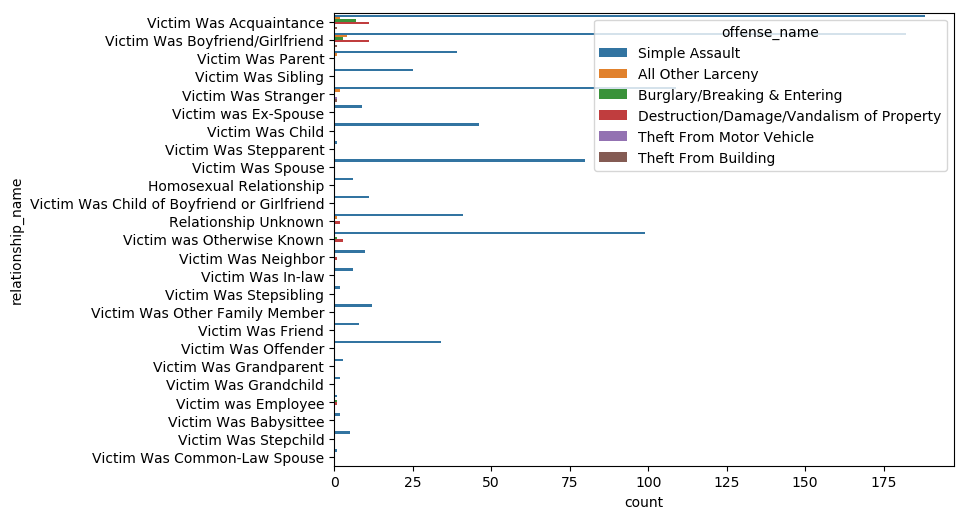

In [25]:
# joinedVictimOffense
plt.figure(figsize=(8,6), dpi=100)
ax = sns.countplot(y = "relationship_name", hue = "offense_name", data = joinedVictimOffense)


In order to normalize the data, filtering out each offense type for computing the normalized values in each series.

In [26]:
filteredDFS = []
# Filter df on the offense name
for offenseName in joinedVictimOffense["offense_name"].unique():
    filteredDFS.append((offenseName, joinedVictimOffense.loc[joinedVictimOffense["offense_name"] == offenseName]))

# Check the number of rows in each df
for element in filteredDFS:
    print(len(element[1]))

922
10
12
29
1
3


Finally, we would like to normalize the relationship counts in each offense type to show the distribution. After normalizing the data, we could concatenate the normalized series into one dataframe and could draw the distribution of each offense name and its distribution as a side-by-side barplot using seaborn's `factorplot`. 

/Users/xiaoyuq/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:1508: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data[hue_mask])


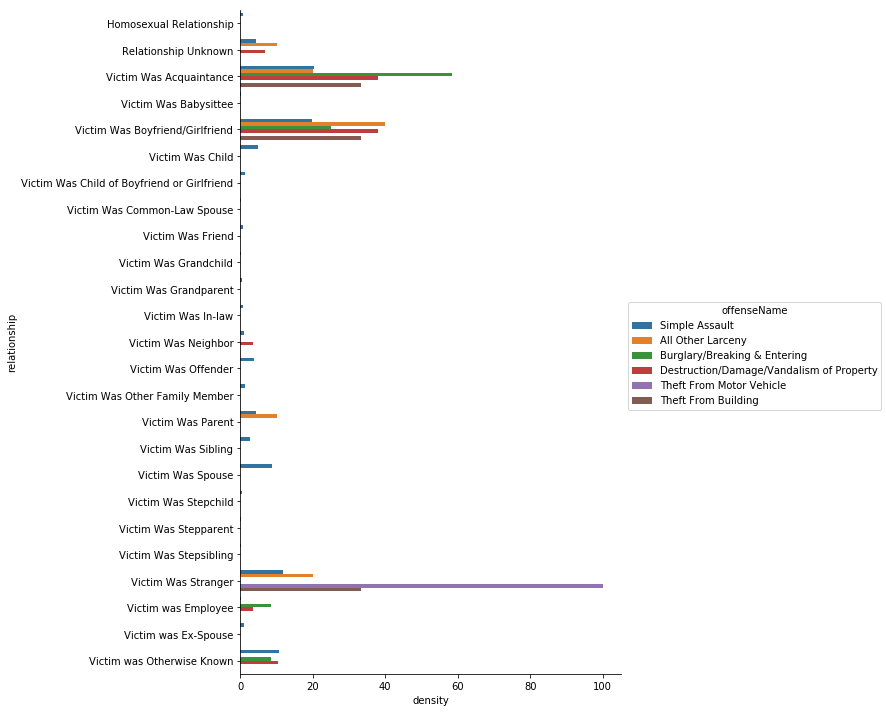

In [27]:
# https://stackoverflow.com/questions/18083187/combining-two-series-in-pandas-along-their-index
# Use "concat" to concat two series with different indices or dimensions
normalizedDFS = [(df[0], pd.Series(df[1]["relationship_name"]).value_counts(normalize=True, sort=False)*100) for df in filteredDFS]
concatDF = pd.concat([elem[1] for elem in normalizedDFS], axis = 1).fillna(value = 0.0).reset_index()
concatDF.columns = ["relationship"] + [elem[0] for elem in normalizedDFS]

# https://stackoverflow.com/questions/38807895/seaborn-multiple-barplots
# Plot multiple cols data with pd.melt and factorplot
reshapeDF = pd.melt(concatDF, id_vars="relationship", var_name="offenseName", value_name="density")
sns.factorplot(x="density", y="relationship", hue="offenseName", data = reshapeDF, kind= "bar", size = 10)

### Offender-victim Age Comparison

In this section, we will compare the age distributions of offenders and victims to see if they are similar.

First, let's plot each distribution in a histogram.

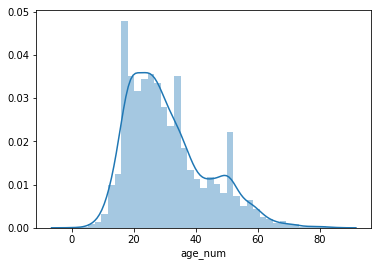

In [28]:
# Offender age distribution
fig = sns.distplot(PA2016['nibrs_offender'].dropna(subset=['age_num'])['age_num'])

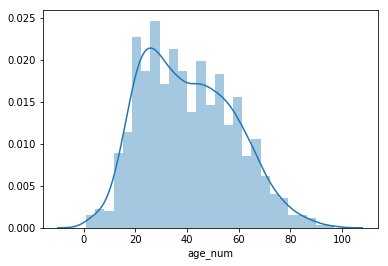

In [29]:
# Victim age distribution
fig = sns.distplot(PA2016['nibrs_victim'].dropna(subset=['age_num'])['age_num'])

We can see that starting at age 30, offender density decreases significantly faster than victim density.

Next, we will use box plots to show age distribution of offenders and victims grouped by top 10 offense types.

To to that, we will merge DataFrames to as `incident_offense_offender` and `incident_offense_victim`.

Also, create another categorical variable `role` = `{'offender', 'victim'}`.

In [30]:
PA2016['incident_offense_offender'] = \
    PA2016['incident_offense'].merge(PA2016['nibrs_offender'], on='incident_id').assign(role='offender')
PA2016['incident_offense_victim'] = \
    PA2016['incident_offense'].merge(PA2016['nibrs_victim'], on='incident_id').assign(role='victim')

Then, concatenate the two DataFrames into one so we can group by the `role` variable.

In [31]:
PA2016['offender_victim_concat'] = pd.concat([PA2016['incident_offense_offender'], 
                                              PA2016['incident_offense_victim']])

Finally, produce a box plot of offender-victim age distributions grouped by top 10 offense types.

/Users/xiaoyuq/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:490: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data[hue_mask])


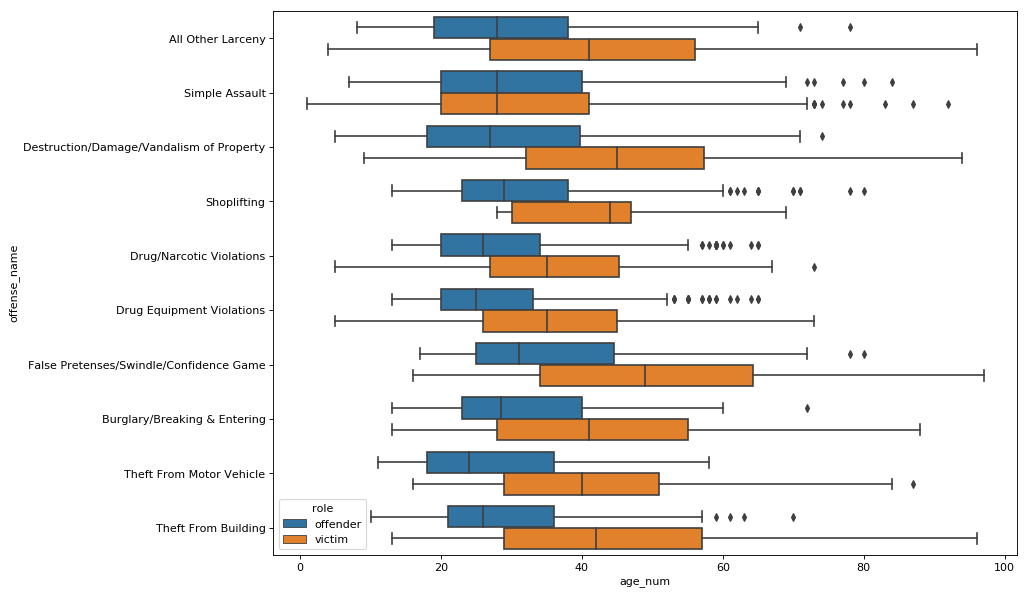

In [32]:
# topCrimeTypes = countPlot(PA2016['nibrs_offense'], 'offense_name', topK=10, ret=True)
plt.figure(figsize=(12, 9), dpi=80)
fig = sns.boxplot(data=PA2016['offender_victim_concat'], x='age_num', y='offense_name',
                  hue='role', order=topCrimeTypes)

In general, the offenders are noticibly younger than the victims in all offense types except for simple assault, where the age distributions are much more similar.

## Offender Feature Prediction

### Pre-processing SC-2016 Data

In order to build a robust model, we need a larger dataset than PA2016. In this project we used South California dataset (SC2016) which is 5 times larger.

In [33]:
SC2016 = readCSVs('SC-2016')
print('Replacing and Renaming columns...')
replaceAndRename(SC2016['nibrs_incident'], ['nibrs_month'])
replaceAndRename(SC2016['nibrs_offense'], ['nibrs_location_type', 'nibrs_offense_type'])
replaceAndRename(SC2016['nibrs_offender'], ['ref_race', 'nibrs_ethnicity'])
replaceAndRename(SC2016['nibrs_arrestee'], ['nibrs_offense_type', 'ref_race', 'nibrs_ethnicity'])
replaceAndRename(SC2016['nibrs_victim'], ['nibrs_victim_type', 'ref_race', 'nibrs_ethnicity'])
replaceAndRename(SC2016['nibrs_victim_offender_rel'], ['nibrs_relationship'])
replaceAndRename(SC2016['nibrs_property'], ['nibrs_prop_loss_type'])
replaceAndRename(SC2016['nibrs_property_desc'], ['nibrs_prop_desc_type'])
print('Done')

Reading all CSVs for SC-2016 dataset...
Finished reading 43 CSVs
Replacing and Renaming columns...
Done


Next we will create a dataframe containing all the columns with meaningful information associated with incident, victim, offender and offense.

We selected the following features as input:
 - victim age
 - victim sex
 - victim race
 - victim ethnicity
 - victim resident status
 - victim type
 - victim sequence number
 - time of the incident
 - type of injury
 - offense type
 
And selected the following features as prediction output:
age (int)
 - offender age
 - offender sex
 - offender race
 - offender ethnicity
 - relationship
 - bias type

In [34]:
def formalizePersonalInfo(rawDF, identity):
    """
    Select valid ages and rename some columns of the dataframe containin personal information
    Args:
        rawDF (DataFrame): DataFrame to be formalized
        df (DataFrame): Formalized dataframe
    """
    return rawDF[rawDF['age_id'] == 5.0].drop('age_id', axis=1)\
.rename(columns={"age_num": identity + "_age","sex_code": identity + "_sex", "race_desc": identity + "_race", \
                "ethnicity_name": identity + "_ethnicity", "resident_status_code": identity + "_resident_status"})

# First select the data frame with victim_id and offender_id, and merge other dataframes into it by matching victim_id.
dataframe = formalizePersonalInfo(SC2016["nibrs_victim_offender_rel"].merge(SC2016['nibrs_victim'], how='left', on='victim_id')\
                                  .merge(SC2016['nibrs_incident'], how='left', on='incident_id')\
                                  [['victim_id', 'offender_id', 'incident_id', 'relationship_name',\
                                    'victim_seq_num', 'victim_type_name','age_id', 'age_num', 'sex_code','month_num', \
                                    'race_desc', 'ethnicity_name', 'resident_status_code', 'incident_date']], 'victim')

# Continue to merge dataframes to diversify the information.
dataframe = formalizePersonalInfo(dataframe.merge(SC2016['nibrs_victim_injury'], how = 'left', on = 'victim_id')
                                  .merge(SC2016['nibrs_injury'], how = 'left', on = 'injury_id')\
                                  .drop(['injury_id', 'injury_code'], axis=1)\
                                  .merge(SC2016['nibrs_offender'], how = 'left',\
                                         on = ['incident_id', 'offender_id'])\
                                  .drop(['ff_line_number', 'age_range_low_num', 'age_range_high_num'], axis = 1)\
                                  .merge(SC2016['nibrs_offense'], how = 'left', on = 'incident_id')\
                                  .drop(['attempt_complete_flag', 'location_name', 'num_premises_entered',\
                                         'method_entry_code', 'ff_line_number'], axis=1)\
                                  .merge(SC2016['nibrs_bias_motivation'], how = 'left', on = 'offense_id')\
                                  .merge(SC2016['nibrs_bias_list'], how = 'left', on = 'bias_id')\
                                  .drop(['victim_id', 'offender_id', 'incident_id', 'offense_id', 'bias_id',\
                                         'bias_code'], axis=1), 'offender')

dataframe.tail()

,relationship_name,victim_seq_num,victim_type_name,victim_age,victim_sex,month_num,victim_race,victim_ethnicity,victim_resident_status,incident_date,injury_name,offender_seq_num,offender_age,offender_sex,offender_race,offender_ethnicity,offense_name,bias_name
152634,Victim Was Stranger,2,Individual,24.0,F,7649079,Black or African American,Not Hispanic or Latino,N,2016-12-06 00:00:00,None,1,29.0,F,Black or African American,Not Hispanic or Latino,Simple Assault,None
152635,Victim Was Acquaintance,1,Individual,57.0,F,7649079,White,Not Hispanic or Latino,R,2016-12-31 00:00:00,Minor Injury,2,57.0,F,White,Not Hispanic or Latino,Simple Assault,None
152636,Victim Was Acquaintance,1,Individual,57.0,F,7649079,White,Not Hispanic or Latino,R,2016-12-31 00:00:00,Minor Injury,1,43.0,F,White,Not Hispanic or Latino,Simple Assault,None
152637,Victim Was Acquaintance,2,Individual,43.0,F,7649079,White,Not Hispanic or Latino,R,2016-12-31 00:00:00,Minor Injury,1,43.0,F,White,Not Hispanic or Latino,Simple Assault,None
152638,Victim Was Acquaintance,2,Individual,43.0,F,7649079,White,Not Hispanic or Latino,R,2016-12-31 00:00:00,Minor Injury,2,57.0,F,White,Not Hispanic or Latino,Simple Assault,None


Select the data size and shuffle the data.

In [35]:
data_size = 50000
training_size = int(data_size * 0.9)

dataframe = shuffle(dataframe).iloc[:data_size,:]

### Baseline Model

Base line prediction for offender features:
  - for numerial feature (offender_age), compute the mean value of the training data.
  - for categorical features, select the most frequency catogory.

From the base line prediction, we notice that ethiniciy and bias are imbalanced, so we will mark down these two features and discuss the their covariance matrices later.

In [36]:
age_base = dataframe['offender_age'].mean()

print('Base line prediction of offender_age: ', age_base)
print()
relationship_count = dataframe['relationship_name'].value_counts()
relationship_base = relationship_count.idxmax()
sex_count = dataframe['offender_sex'].value_counts()
sex_base = sex_count.idxmax()
race_count = dataframe['offender_race'].value_counts()
race_base = race_count.idxmax()
ethnicity_count = dataframe['offender_ethnicity'].value_counts()
ethnicity_base = ethnicity_count.idxmax()
bias_count = dataframe['bias_name'].value_counts()
bias_base = bias_count.idxmax()

print('Base line prediction of relationship_name: ', relationship_base)
print('Base line accuracy of relationship_name: ', relationship_count.max() / relationship_count.sum())
print()
print('Base line prediction of sex: ', sex_base)
print('Base line accuracy of offender_sex: ', sex_count.max() / sex_count.sum())
print()
print('Base line prediction of race: ', race_base)
print('Base line accuracy of offender_race: ', race_count.max() / race_count.sum())
print()
print('Base line prediction of ethnicity: ', ethnicity_base )
print('Base line accuracy of offender_ethnicity: ', ethnicity_count.max() / ethnicity_count.sum())
print()
print('Base line prediction of bias: ', bias_base)
print('Base line accuracy of bias_name: ', bias_count.max() / bias_count.sum())

Base line prediction of offender_age:  31.46356

Base line prediction of relationship_name:  Victim Was Acquaintance
Base line accuracy of relationship_name:  0.23952

Base line prediction of sex:  M
Base line accuracy of offender_sex:  0.69756

Base line prediction of race:  Black or African American
Base line accuracy of offender_race:  0.54002

Base line prediction of ethnicity:  Not Hispanic or Latino
Base line accuracy of offender_ethnicity:  0.936033950617284

Base line prediction of bias:  None
Base line accuracy of bias_name:  0.99878


### Feature Engineering

Now we get the large dataframe that includes all the data needed to predict the offender.
In order to exploit the input features, we want to manipulate the current features and generate some new.

  - Add a feature called 'week_of_day' to indicate the index of day in a week (int)
  - Add a feature called 'is_weekend' to indicate whether the day is at weekend (boolean)
  - Add a feature called 'is_holiday' to indicate whether the day is in holiday (boolean)

For numerial input features, we want to do feature scaling so that each feature contributes approximately proportionately to the output.

For categorial input feature, we want to do One Hot Encode to fit in input datatype of the model.

In [37]:
# Use datetime.weekday() to create a column called 'week_of_day'
dataframe['incident_date'] = pd.to_datetime(dataframe['incident_date'])
dataframe['week_of_day'] = dataframe['incident_date'].apply(lambda x: x.weekday())

# Create a column called 'is_weekend' using week_of_day
dataframe['is_weekend'] = dataframe['week_of_day'].apply(lambda x: x > 4)

# Use pandas.tseries.holiday and datetime.weekday() to create a column called 'is_holiday'
cal = USFederalHolidayCalendar()
holidays = cal.holidays()
dataframe['is_holiday'] = dataframe['incident_date'].isin(holidays)

Then we will select input and output features from the large dataframe, and create two new dataframes.

Since the output features can be categorial and numerial, we divided output features into two dataframes in terms of their data type.

In [38]:
# Categorical output features
categorial_output = dataframe[['relationship_name', 'offender_sex', 'offender_race', 'offender_ethnicity', 'bias_name']]
# Numerial output feature
numerial_output = dataframe[['offender_age']]

# Input feature
inputFeature = dataframe.drop(['relationship_name', 'offender_seq_num', 'offender_age', 'offender_sex', 'offender_race',\
                          'offender_ethnicity', 'bias_name', 'incident_date'], axis=1)

inputFeature.tail()

,victim_seq_num,victim_type_name,victim_age,victim_sex,month_num,victim_race,victim_ethnicity,victim_resident_status,injury_name,offense_name,week_of_day,is_weekend,is_holiday
57898,2,Individual,56.0,F,7645432,White,Not Hispanic or Latino,R,None,Simple Assault,1,False,False
8731,1,Individual,33.0,M,7481292,Black or African American,Not Hispanic or Latino,R,Apparent Broken Bones,Aggravated Assault,0,False,False
71707,2,Individual,18.0,F,7378597,Black or African American,Not Hispanic or Latino,R,None,Simple Assault,2,False,False
30626,1,Individual,73.0,M,7649246,White,Not Hispanic or Latino,R,NaN,Intimidation,5,True,False
54350,1,Individual,23.0,M,7276895,Black or African American,Not Hispanic or Latino,R,Minor Injury,Aggravated Assault,5,True,False


In [39]:
def scaleFeature(rawDF, columnName):
    """
    Scale numerial features to 0~1.
    Args:
        rawDF (DataFrame): DataFrame to be scaled
        df (DataFrame): Scaled dataframe
    """
    rawDF[columnName] = rawDF[columnName].apply(lambda x: x / dataframe[columnName].max())
    return rawDF

def OHE(rawDF, columnName):
    """
    Convert Categorical features into multiple binary values
    Args:
        rawDF (DataFrame): DataFrame to be scaled
        df (DataFrame): Scaled dataframe
    """
    return rawDF.join(pd.get_dummies(dataframe[columnName]), lsuffix='v', rsuffix='o').drop(columnName, axis=1)


# First deal with intput numerical features.
inputFeature = scaleFeature(scaleFeature(scaleFeature(scaleFeature(inputFeature, 'victim_seq_num'),\
                                                   'victim_age'), 'month_num'), 'week_of_day')

# Then convert input categorical features.
inputFeature = OHE(OHE(OHE(OHE(OHE(OHE(OHE(inputFeature, 'victim_type_name'), 'victim_sex'), 'victim_race'), 'victim_ethnicity'),\
                'victim_resident_status'), 'injury_name'), 'offense_name')

inputFeature.tail()

,victim_seq_num,victim_age,month_num,week_of_day,is_weekend,is_holiday,Individual,Law Enforcement Officer,F,M,Uv,American Indian or Alaska Native,Asian,Black or African American,Native Hawaiian or Other Pacific Islander,Unknownv,White,Hispanic or Latino,Not Hispanic or Latino,Unknowno,N,R,Uo,Apparent Broken Bones,Loss of Teeth,Minor Injury,None,Other Major Injury,Possible Internal Injury,Severe Laceration,Unconscious,Aggravated Assault,All Other Larceny,Arson,Bribery,Burglary/Breaking & Entering,Counterfeiting/Forgery,Credit Card/Automated Teller Machine Fraud,Destruction/Damage/Vandalism of Property,Drug Equipment Violations,Drug/Narcotic Violations,Embezzlement,Extortion/Blackmail,False Pretenses/Swindle/Confidence Game,Fondling,Gambling Equipment Violation,"Human Trafficking, Commercial Sex Acts","Human Trafficking, Involuntary Servitude",Impersonation,Incest,Intimidation,Justifiable Homicide,Kidnapping/Abduction,Motor Vehicle Theft,Murder and Nonnegligent Manslaughter,Negligent Manslaughter,Pocket-picking,Pornography/Obscene Material,Prostitution,Purse-snatching,Rape,Robbery,Sexual Assault With An Object,Shoplifting,Simple Assault,Sodomy,Statutory Rape,Stolen Property Offenses,Theft From Building,Theft From Motor Vehicle,Theft of Motor Vehicle Parts or Accessories,Weapon Law Violations,Welfare Fraud
57898,0.083333,0.571429,0.975504,0.166667,False,False,1,0,1,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
8731,0.041667,0.336735,0.954561,0.000000,False,False,1,0,0,1,0,0,0,1,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
71707,0.083333,0.183673,0.941457,0.333333,False,False,1,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
30626,0.041667,0.744898,0.975990,0.833333,True,False,1,0,0,1,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
54350,0.041667,0.234694,0.928481,0.833333,True,False,1,0,0,1,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In order to facilitate evaluating models, here we create several ground truth numpy arrays for different output features.


The last step is to convert dataframes into numpy arrays and convert categorial datype into string.

Yeah! we have transformed the data well fitted into models!

In [40]:
inputFeature = inputFeature.as_matrix()
categorial_output = categorial_output.as_matrix()
categorial_output = categorial_output.astype(str)
numerial_output = numerial_output.as_matrix().ravel()

output_relationship_name = categorial_output[:, 0]
output_offender_age = numerial_output
output_offender_sex = categorial_output[:, 1]
output_offender_race = categorial_output[:, 2]
output_offender_ethnicity = categorial_output[:, 3]
output_bias_name = categorial_output[:, 4]


print(categorial_output)

[['Victim Was Boyfriend/Girlfriend' 'M' 'White' 'nan' 'None']
 ['Relationship Unknown' 'M' 'White' 'nan' 'None']
 ['Victim Was Acquaintance' 'M' 'Black or African American' 'nan' 'None']
 ...
 ['Victim Was Acquaintance' 'F' 'Black or African American' 'nan' 'None']
 ['Relationship Unknown' 'M' 'White' 'Not Hispanic or Latino' 'None']
 ['Victim Was Offender' 'M' 'Black or African American' 'nan' 'None']]


### Final Models

We used sklearn.multioutput.MultiOutputClassifier to generate multiple categorical output features, and tried different estimators in the classifier.

Since there's only one numerical ouput feature (offender_age), we don't need to use MultiOutputRegressor here.

In [41]:
# Multiple regressors
nb = GaussianNB()
lr = LinearRegression()
loR = LogisticRegression()
gbr = GradientBoostingRegressor()

# Initialize multiple estimators for classifier
dt = DecisionTreeClassifier()
svc = SVC()
gbc = GradientBoostingClassifier()
rfc = RandomForestClassifier()
etc = ExtraTreesClassifier()

# Create different multiclassifiers for different estimators
multi_classifier_dt = MultiOutputClassifier(dt, n_jobs=-1)
multi_classifier_svc = MultiOutputClassifier(svc, n_jobs=-1)
multi_classifier_gbc = MultiOutputClassifier(gbc, n_jobs=-1)
multi_classifier_rfc = MultiOutputClassifier(rfc, n_jobs=-1)
multi_classifier_etc = MultiOutputClassifier(etc, n_jobs=-1)


nb.fit(inputFeature[:training_size,:], output_relationship_name[:training_size])
lr.fit(inputFeature[:training_size,:], output_offender_age[:training_size])

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

- Fit data into MultiOutputClassifier - Decision Tree model.

In [42]:
multi_classifier_dt.fit(inputFeature[:training_size,:], categorial_output[:training_size, :])
categorical_predict_dt = multi_classifier_dt.predict(inputFeature[training_size:, :])

- Fit data into MultiOutputClassifier - Support Vector Classifier model.

In [43]:
multi_classifier_svc.fit(inputFeature[:training_size,:], categorial_output[:training_size, :])
categorical_predict_svc = multi_classifier_svc.predict(inputFeature[training_size:, :])

- Fit data into MultiOutputClassifier - Gradient Boosting Classifier model.

In [44]:
multi_classifier_gbc.fit(inputFeature[:training_size,:], categorial_output[:training_size, :])
categorical_predict_gbc = multi_classifier_gbc.predict(inputFeature[training_size:, :])

- Fit data into MultiOutputClassifier - Random Forest Classifier model.

In [45]:
multi_classifier_rfc.fit(inputFeature[:training_size,:], categorial_output[:training_size, :])
categorical_predict_rfc = multi_classifier_rfc.predict(inputFeature[training_size:, :])

- Fit data into MultiOutputClassifier - Extra Trees Classifier model.

In [46]:
multi_classifier_etc.fit(inputFeature[:training_size,:], categorial_output[:training_size, :])
categorical_predict_etc = multi_classifier_etc.predict(inputFeature[training_size:, :])

-  Fit numerial input feature (victim_age) into Gradient Boosting Regressor

In [47]:
gbr.fit(inputFeature[:training_size,:], numerial_output[:training_size])
numerial_predict_gbr = gbr.predict(inputFeature[training_size:, :])

-  Fit numerial input feature (victim_age) into Liner Regression

In [48]:
lr.fit(inputFeature[:training_size,:], numerial_output[:training_size])
numerial_predict_lr = lr.predict(inputFeature[training_size:, :])

-  Fit numerial input feature (victim_age) into Logistic Regression

In [49]:
loR.fit(inputFeature[:training_size,:], numerial_output[:training_size])
numerial_predict_loR = loR.predict(inputFeature[training_size:, :])

### Prediction Results

Once we have predicted all the offenders' features, we can compute MSE of numerial features and accuracy of categorical features, and compare with the base line prediction.

Comparing the MSE of offender_age in different models, we found that **Gradient Boosting Regressor** has the least mean squared error, and logisic regression performs even worse than base line prediction.

In [50]:
age_MSE_base = ((age_base - numerial_output[training_size:]) ** 2).mean()
age_MSE_gbr = ((numerial_predict_gbr - numerial_output[training_size:]) ** 2).mean()
age_MSE_lr = ((numerial_predict_lr - numerial_output[training_size:]) ** 2).mean()
age_MSE_loR = ((numerial_predict_loR - numerial_output[training_size:]) ** 2).mean()

print('MSE of base line prediction: ', age_MSE_base)
print('MSE of Gradient Boosting Regressor prediction: ', age_MSE_gbr)
print('MSE of Linear Regression prediction: ', age_MSE_lr)
print('MSE of Logistic Regression prediction: ', age_MSE_loR)

MSE of base line prediction:  175.42197208160002
MSE of Gradient Boosting Regressor prediction:  129.0064859454978
MSE of Linear Regression prediction:  135.53644407443701
MSE of Logistic Regression prediction:  190.411


Then we calculate and compare the accuracy of different models in different features.

From the Accuracy Table shown below, we can see that **Gradient Boosting Classifier** performs best among all algorithms.

Among all features, models could predict much better than base line in **Race** and **Ethnicity**, which might contribute to narrowing down the search scope of offenders.

In [51]:
accuracy = np.zeros((5, 6))

accuracy[0, 0] = np.sum(categorial_output[training_size:, 0] == relationship_base) / categorial_output[training_size:, 0].shape[0]
accuracy[1, 0] = np.sum(categorial_output[training_size:, 1] == sex_base) / categorial_output[training_size:, 1].shape[0]
accuracy[2, 0] = np.sum(categorial_output[training_size:, 2] == race_base) / categorial_output[training_size:, 2].shape[0]
accuracy[3, 0] = np.sum(categorial_output[training_size:, 3] == ethnicity_base) / categorial_output[training_size:, 3].shape[0]
accuracy[4, 0] = np.sum(categorial_output[training_size:, 4] == bias_base) / categorial_output[training_size:, 4].shape[0]

for i in range(5):
    accuracy[i, 1] = np.sum(categorical_predict_dt[:, i] == categorial_output[training_size:, i]) / categorial_output[training_size:, i].shape[0]
    accuracy[i, 2] = np.sum(categorical_predict_svc[:, i] == categorial_output[training_size:, i]) / categorial_output[training_size:, i].shape[0]
    accuracy[i, 3] = np.sum(categorical_predict_gbc[:, i] == categorial_output[training_size:, i]) / categorial_output[training_size:, i].shape[0]
    accuracy[i, 4] = np.sum(categorical_predict_rfc[:, i] == categorial_output[training_size:, i]) / categorial_output[training_size:, i].shape[0]
    accuracy[i, 5] = np.sum(categorical_predict_etc[:, i] == categorial_output[training_size:, i]) / categorial_output[training_size:, i].shape[0]

print('Accuracy Table:')
print(pd.DataFrame(accuracy, np.array(['Relationship', 'Sex', 'Race', 'Ethnicity', 'Bias']), \
                  np.array(['Base line', 'DT', 'SVC', 'GBC', 'RFC', 'ETC'])))

Accuracy Table:
              Base line      DT     SVC     GBC     RFC     ETC
Relationship     0.2382  0.2746  0.2908  0.3398  0.3022  0.2964
Sex              0.7046  0.6206  0.7046  0.7230  0.6608  0.6476
Race             0.5474  0.7804  0.8490  0.8522  0.8338  0.8200
Ethnicity        0.2366  0.8570  0.7462  0.8768  0.8750  0.8592
Bias             0.9982  0.9978  0.9982  0.9982  0.9982  0.9980


Apart from accuracy, we further looked into the **confusion matrix** to visualize the performance of Gradient Boosting Classifier.

In [52]:
relationship_list = ['Victim Was Acquaintance', 'Victim Was Babysittee', 'Victim Was Boyfriend/Girlfriend',
 'Victim Was Child of Boyfriend or Girlfriend', 'Victim Was Child', 'Victim Was Common-Law Spouse',
 'Victim was Employee', 'Victim was Employer', 'Victim Was Friend', 'Victim Was Grandchild',
 'Victim Was Grandparent', 'Homosexual Relationship', 'Victim Was In-law', 'Victim Was Neighbor',
 'Victim Was Other Family Member', 'Victim was Otherwise Known', 'Victim Was Parent',
 'Relationship Unknown', 'Victim Was Sibling', 'Victim Was Stepchild', 'Victim Was Spouse',
 'Victim Was Stepparent', 'Victim Was Stepsibling', 'Victim Was Stranger', 'Victim Was Offender',
 'Victim was Ex-Spouse']
sex_list = ['F', 'nan', 'M', 'U']
race_label = ['Unknown', 'White', 'Black or African American', 'American Indian or Alaska Native', 'Asian',
 'Asian, Native Hawaiian, or Other Pacific Islander', 'Chinese', 'Japanese',
 'Native Hawaiian or Other Pacific Islander', 'Other', 'Multiple', 'Not Specified']
race_list = ['Unknown', 'White', 'Black or African Amerian', 'American Indian or Alaska Native', 'Asian']
ethnicity_list = ['Multiple', 'Hispanic or Latino', 'Not Hispanic or Latino', 'Unknown']

# Compute confusion matrix using sklearn.metrics.confusion_matrix
confusion_matrix_relationship = confusion_matrix(categorial_output[training_size:, 0], categorical_predict_dt[:, 0], labels=relationship_list)
confusion_matrix_sex = confusion_matrix(categorial_output[training_size:, 1], categorical_predict_dt[:, 1], labels=sex_list)
confusion_matrix_race = confusion_matrix(categorial_output[training_size:, 2], categorical_predict_dt[:, 2], labels=race_list)
confusion_matrix_ethnicity = confusion_matrix(categorial_output[training_size:, 3], categorical_predict_dt[:, 3], labels=ethnicity_list)

In [53]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues, featureName=''):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix of " + featureName)
    else:
        print('Confusion matrix, without normalization of ' + featureName)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

From the plot of confusion matrix in offender relationship, we can see a clear diagonal, which means the model could classify many types correctly.

Normalized confusion matrix of relationship


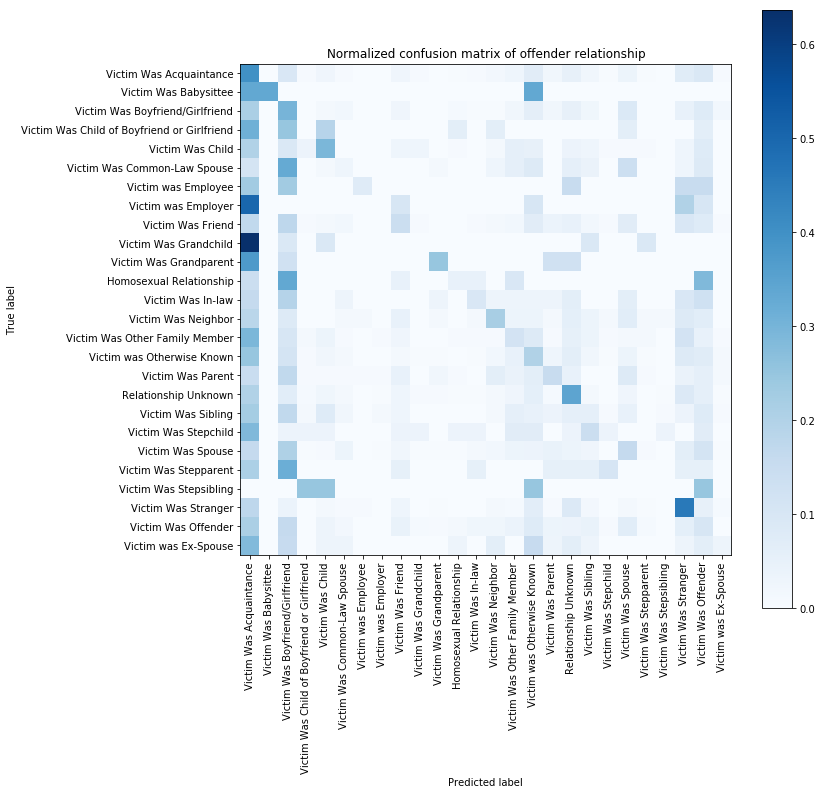

In [54]:
# Plot normalized confusion matrix in relationship
plt.figure(figsize=(11,11))
plot_confusion_matrix(confusion_matrix_relationship, classes=relationship_list, normalize=True,
                      title='Normalized confusion matrix of offender relationship', featureName='relationship')

plt.show()

From the plot of confusion matrix in offender sex, we noticed that the model tends to overclassify 'male'.

Normalized confusion matrix of sex


/Users/xiaoyuq/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.
/Users/xiaoyuq/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:26: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims)


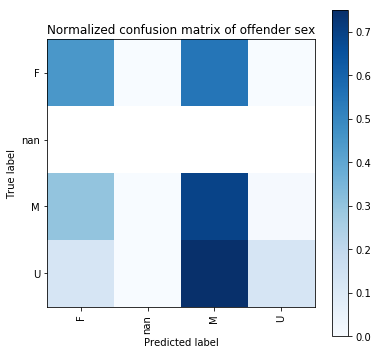

In [55]:
# Plot normalized confusion matrix in sex
plt.figure(figsize=(6,6))
plot_confusion_matrix(confusion_matrix_sex, classes=sex_list, normalize=True,
                      title='Normalized confusion matrix of offender sex', featureName='sex')

plt.show()

From the plot of confusion matrix in offender race, we found that the model often classify 'American or African Amerian' and 'Asian' as 'White'.

/Users/xiaoyuq/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.
/Users/xiaoyuq/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:26: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims)


Normalized confusion matrix of race


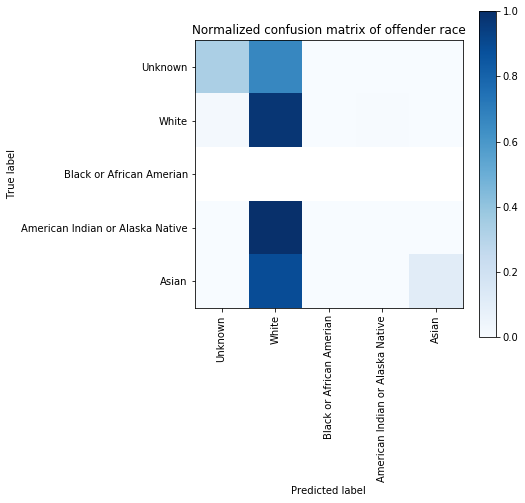

In [56]:
# Plot normalized confusion matrix in race
plt.figure(figsize=(6,6))
plot_confusion_matrix(confusion_matrix_race, classes=race_list, normalize=True,
                      title='Normalized confusion matrix of offender race', featureName = 'race')

plt.show()

From the plot of confusion matrix in offender ethnicity, we found that the model generally classifies different types correctly.

/Users/xiaoyuq/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


Normalized confusion matrix of ethnicity


/Users/xiaoyuq/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:26: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims)


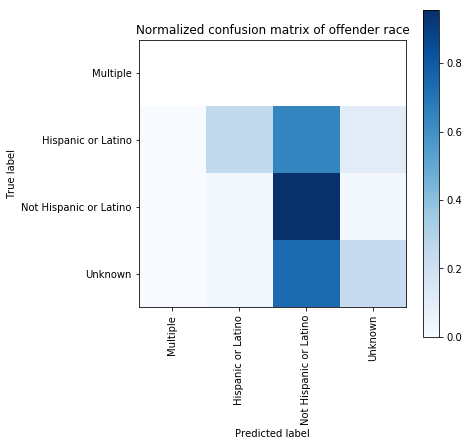

In [57]:
# Plot normalized confusion matrix in ethnicity
plt.figure(figsize=(6,6))
plot_confusion_matrix(confusion_matrix_ethnicity, classes=ethnicity_list, normalize=True,
                      title='Normalized confusion matrix of offender race', featureName = 'ethnicity')

plt.show()

## Summary

From this project, we found some trends that contradict the our common believes. For example, the burglaries committed by acquaintance has the highest ratio compared to other offender/victim relationship. We’ve also found some interesting phenomena. For instance, the offenders generally are younger than the victims in most of the offense type except for simple assault.


The prediction model can predict the offender's race and ethnicity about 85% accuracy, which is much higher than base line prediction. Among all the algorithms we used, gradient boosting has the best performance. From the confusion matrices, we found that our model generally predicts well, but tends to classify relationship as 'acquaintance', sex as 'male', race as 'white'.
